In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from PIL import Image
import arviz as az
from tools import img_slice
from Horseshoe_img_comp import Horseshoe_img_comp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Evaluation of the Horseshoe compression method

In [2]:
block_size = 5 # e.g. 8 means that that 8 x 8 blocks will be considered like in jpeg.
hic = Horseshoe_img_comp(block_size)

## Computing the intensity basis

In [3]:
intensity_basis = hic.compute_basis_intensity_matrix()
intensity_basis = intensity_basis[1:] # The average component (the first one) is dealt with apart

## Computing linear-regression-based compression

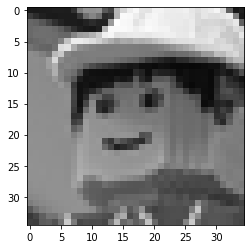

In [4]:
tif_pil = Image.open('images/ucid00652_small.tif').convert('L') # Greyscale image
tif_arr = np.array(tif_pil)
dim_x, dim_y = tif_arr.shape
tif_arr = tif_arr[:dim_x - dim_x % 5,:dim_y - dim_y % 5] # Making sure the image has dimensions multiples of block_size
plt.imshow(tif_arr, cmap="gray", vmin=0, vmax=255)
plt.show()

In [5]:
height_in_blocks = int(tif_arr.shape[0] / block_size)
width_in_blocks = int(tif_arr.shape[1] / block_size)

In [6]:
sliced_img = img_slice(tif_arr, block_size)
compressed_blocks = []
all_coefs_save = []

In [7]:
lin_comp_blocks = []
lin_comp_coefs = []
X = intensity_basis

for block in sliced_img:
    y = block.flatten()
    avg_block = np.mean(y)
    linReg = LinearRegression(fit_intercept=False)
    linReg.fit(X.T, y - avg_block)
    lin_comp_coefs.append(linReg.coef_)
    lin_comp_blocks.append((linReg.coef_ @ X).reshape(block_size, block_size) + avg_block)

## Importing coefficients from the Horseshoe compression

In [8]:
hs_comp_coefs = []
for line_nb in range(1,8):
    with open(f"saves/coefs_line{line_nb}.pckl", "rb") as save_file:
        p = pickle.Unpickler(save_file)
        hs_coefs = p.load()
    hs_comp_coefs += hs_coefs

## Computing the MSE with respect to the original image

Computing the MSE with respect to the original image depending on the chosen number of remaining non-zero coefficients for both the linear and the Horseshoe methods.

In [17]:
mse_list_lin = []
mse_list_hs = []

for i in range(1, block_size ** 2 - 1):
    comp_block_list_lin = [] # Will contain the blocks compressed via linear method
    comp_block_list_hs = []  # Will contain the blocks compressed via horseshoe method
    
    ### Iterating over coefficients and original blocks
    for coef_vect_lin, coef_vect_hs, block in zip(lin_comp_coefs, hs_comp_coefs, sliced_img):
        avg_block = np.mean(block)
        
        ### Sorting coefficients by decreasing absolute value while keeping track of their original order
        sort_coefs_lin = np.zeros((2, block_size ** 2 - 1))
        sort_coefs_hs = np.zeros((2, block_size ** 2 - 1))

        sort_coefs_lin[1] = np.arange(0, block_size ** 2 - 1)
        sort_coefs_hs[1] = np.arange(0, block_size ** 2 - 1)

        sort_coefs_lin[0] = coef_vect_lin.copy()
        sort_coefs_hs[0] = coef_vect_hs.copy()

        sorted_coefs_lin = sort_coefs_lin[:,np.flip(np.abs(sort_coefs_lin[0]).argsort())]
        sorted_coefs_hs = sort_coefs_hs[:,np.flip(np.abs(sort_coefs_hs[0]).argsort())]

        
        
        thres_coefs_vect_lin = coef_vect_lin.copy() # Will contain thresholded linear coefficients
        thres_coefs_vect_hs = coef_vect_hs.copy()   # Will contain thresholded horseshoe coefficients
        
        ### keeping only the ith most significant components and putting the rest to 0.
        zero_indices_lin = sorted_coefs_lin[1, i:].astype(int)
        zero_indices_hs = sorted_coefs_hs[1, i:].astype(int)
        
        thres_coefs_vect_lin[zero_indices_lin] = 0
        thres_coefs_vect_hs[zero_indices_hs] = 0

        ### Reconstruction the compressed blocks using thresholded coefficient vectors
        reconst_lin = (thres_coefs_vect_lin @ intensity_basis).astype(int)  # Reconstructing a compressed block via linear method
        reconst_hs = (thres_coefs_vect_hs @ intensity_basis).astype(int)    # Reconstructing a compressed block via horseshoe method
        
        ### Adding the mean components
        reconst_lin += int(avg_block)
        reconst_hs += int(avg_block)
        
        comp_block_list_lin.append(reconst_lin.reshape(block_size, block_size))
        comp_block_list_hs.append(reconst_hs.reshape(block_size, block_size))
        
    ### Computing the mse for i non-zero components
    mse_list_lin.append(mse(np.hstack(comp_block_list_lin), np.hstack(sliced_img)))
    mse_list_hs.append(mse(np.hstack(comp_block_list_hs), np.hstack(sliced_img)))

## Displaying the comparison

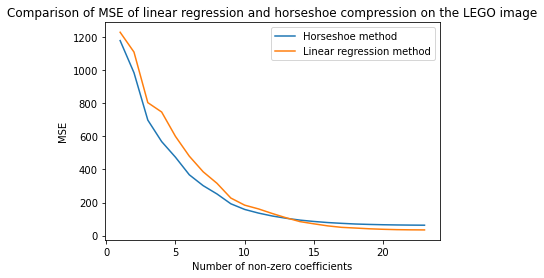

In [18]:
plt.plot(range(1, block_size ** 2 - 1), mse_list_hs, label="Horseshoe method")
plt.plot(range(1, block_size ** 2 - 1), mse_list_lin, label="Linear regression method")
plt.title("Comparison of MSE of linear regression and horseshoe compression on the LEGO image")
plt.xlabel("Number of non-zero coefficients")
plt.ylabel("MSE")
plt.legend()
plt.show()

As expected, the Horseshoe method performs better with less coefficients.  

However, it is not as good as the linear method when considering many coefficient. This makes sense: the linear problem consisting in expressing a 5 x 5 block in the intensity basis has an exact solution, found by the linear regression. The sparse solution is therefore not as good when considering all (or most) coefficients.  

As a conslusion, the horseshoe method performs better (at least on this image) than a standard feature selection when compressing a lot.